In [1]:
!pip install torchmetrics
!pip install -q pytorch-lightning
!pip install -q wandb
!pip install -q datasets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 891.4/891.4 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
import torchmetrics
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import pytorch_lightning as pl
import torchmetrics
import wandb
import datasets
from torchmetrics import ConfusionMatrix
import seaborn as sns

In [3]:
wandb.login()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
# we will use these later for the CNN
resolution = 112
num_classes = 3
batch_size = 32
num_workers = 2
num_epochs = 10
learning_rate = 3e-4
weight_decay = 1e-4
width = 64

In [5]:
class DogFoodDataModule(pl.LightningDataModule):
    def __init__(self):
        super().__init__()
        self.train_transform = transforms.Compose([
            transforms.RandomResizedCrop(size=resolution, scale=(0.25, 1.0), antialias=True),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),  # Color Jitter for brightness, contrast, saturation
            transforms.RandomRotation(degrees=15),  # Random rotation of 15 degrees
            transforms.ToTensor(),
            # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        self.val_transform = transforms.Compose([
            transforms.Resize(size=resolution, antialias=True),
            transforms.CenterCrop(size=resolution),
            transforms.ToTensor(),
            # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

    def preprocess_train(self, batch):
        batch["image"] = [self.train_transform(image) for image in batch["image"]]
        return batch

    def preprocess_val(self, batch):
        batch["image"] = [self.val_transform(image) for image in batch["image"]]
        return batch

    def setup(self, stage=None):
        self.train_dataset = datasets.load_dataset(
            "lewtun/dog_food", split="train"
        ).with_transform(self.preprocess_train)
        self.val_dataset = datasets.load_dataset(
            "lewtun/dog_food", split="test"
        ).with_transform(self.preprocess_val)

    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            self.train_dataset,
            batch_size=batch_size,
            num_workers=num_workers,
            pin_memory=True,
            drop_last=True,
            shuffle=True,
        )

    def val_dataloader(self):
        return torch.utils.data.DataLoader(
            self.val_dataset,
            batch_size=batch_size,
            num_workers=num_workers,
            pin_memory=True,
        )

    def test_dataloader(self):
        return self.val_dataloader()


In [6]:
datamodule = DogFoodDataModule()
datamodule.prepare_data()
datamodule.setup()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/4.34k [00:00<?, ?B/s]

dataset_infos.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

(…)-00000-of-00001-e911c635bb007d15.parquet:   0%|          | 0.00/217M [00:00<?, ?B/s]

(…)-00000-of-00001-72eb355cf5eb6762.parquet:   0%|          | 0.00/67.9M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2250 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/750 [00:00<?, ? examples/s]

In [7]:
def visualize_images(dataset, num_images, num_augmentations):
    class_names = ["chicken", "dog", "muffin"]
    plt.figure(figsize=(num_augmentations * 2, num_images * 2))
    for row in range(num_images):
        for column in range(num_augmentations):
            image = dataset[row]["image"]
            label = dataset[row]["label"]
            plt.subplot(num_images, num_augmentations, num_augmentations * row + column + 1)
            plt.imshow(image.cpu().permute(1, 2, 0).numpy())
            if column == 0:
                plt.title(class_names[label], loc="left")
            plt.axis("off")
    plt.tight_layout()
    plt.show()

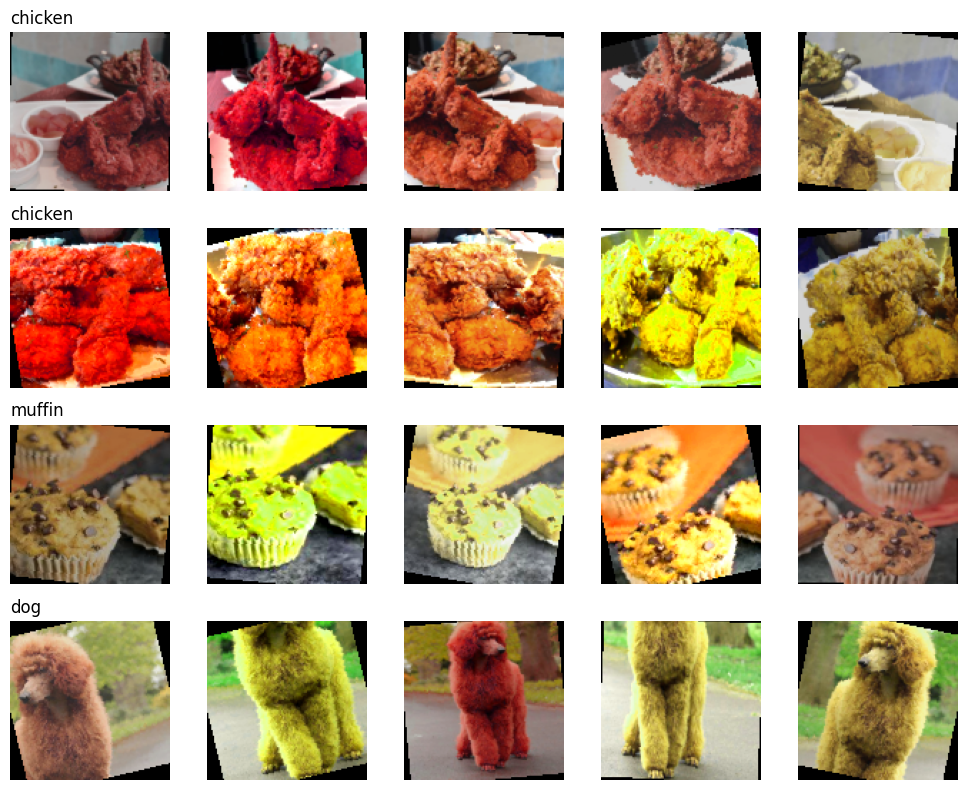

In [8]:
visualize_images(datamodule.train_dataset, num_images=4, num_augmentations=5)

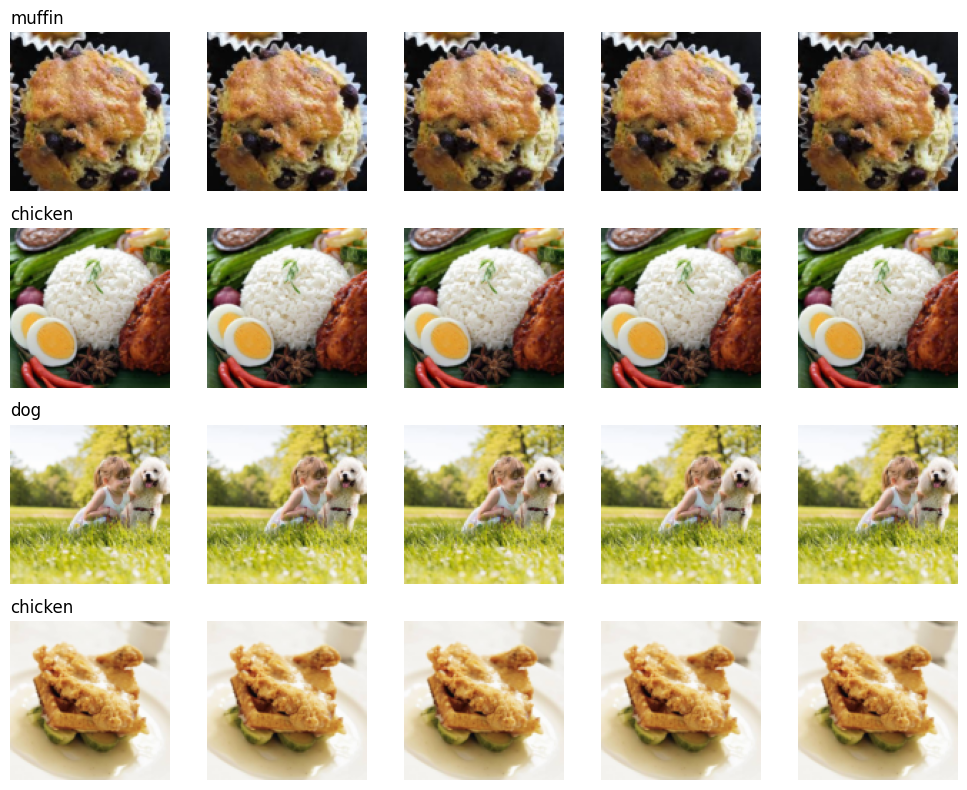

In [9]:
visualize_images(datamodule.val_dataset, num_images=4, num_augmentations=5)

In [10]:
#Here we define confussion Matrix
class ConfusionMatrixVisualizer:
    def __init__(self, num_classes, class_names=None):
        self.num_classes = num_classes
        self.confmat_metric = ConfusionMatrix(task="multiclass", num_classes=num_classes)
        self.class_names = class_names if class_names else [str(i) for i in range(num_classes)]
        self.predictions = []
        self.ground_truths = []

    def set_device(self, device):
        """Move confusion matrix metric to the specified device."""
        self.confmat_metric = self.confmat_metric.to(device)

    def update(self, preds, targets):
        # Append predictions and targets, ensuring they're on the same device
        self.predictions.append(preds.to(self.confmat_metric.device))
        self.ground_truths.append(targets.to(self.confmat_metric.device))

    def compute_and_plot(self):
        # Concatenate all predictions and ground truths
        preds = torch.cat(self.predictions)
        targets = torch.cat(self.ground_truths)

        # Compute confusion matrix
        confmat = self.confmat_metric(preds, targets).cpu().numpy()

        # Plot the confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(confmat, annot=True, fmt="d", cmap="Blues",
                    xticklabels=self.class_names, yticklabels=self.class_names)
        plt.xlabel("Predicted Labels")
        plt.ylabel("True Labels")
        plt.title("Confusion Matrix")
        plt.show()

        # Clear stored data for reuse
        self.predictions.clear()
        self.ground_truths.clear()


In [11]:
class ImageClassifier(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        # Initialize confusion matrix visualizer with class names
        class_names = ["chicken", "dog", "muffin"]
        self.confmat_visualizer = ConfusionMatrixVisualizer(num_classes=num_classes, class_names=class_names)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        pred_labels = self(batch["image"])

        loss = F.cross_entropy(pred_labels, batch["label"])
        accuracy = self.accuracy(pred_labels, batch["label"])

        self.log("train_loss", loss, on_epoch=True)
        self.log("train_acc", accuracy, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        pred_labels = self(batch["image"])

        loss = F.cross_entropy(pred_labels, batch["label"])
        accuracy = self.accuracy(pred_labels, batch["label"])

        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", accuracy, prog_bar=True)
        # Update confusion matrix visualizer with predictions and ground truths
        self.confmat_visualizer.update(pred_labels.argmax(dim=1), batch["label"])
        return loss
    def on_validation_epoch_end(self):
        # Plot confusion matrix after validation epoch ends
        self.confmat_visualizer.compute_and_plot()

    def test_step(self, batch, batch_idx):
        images, labels = batch
        pred_labels = self(images)

        loss = F.cross_entropy(pred_labels, labels)
        accuracy = self.accuracy(pred_labels, labels)

        self.log("test_loss", loss)
        self.log("test_acc", accuracy)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=learning_rate)
        # return torch.optim.AdamW(self.parameters(), lr=learning_rate, weight_decay=weight_decay)
        # return torch.optim.AdamW(self.model.classifier[-1].parameters(), lr=learning_rate, weight_decay=weight_decay)

In [12]:
model = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=3, out_channels=width, kernel_size=3, stride=2, padding=1),
    torch.nn.BatchNorm2d(width),  # Batch normalization after the first conv layer
    torch.nn.ReLU(),

    torch.nn.Conv2d(in_channels=width, out_channels=width, kernel_size=3, stride=2, padding=1),
    torch.nn.BatchNorm2d(width),  # Batch normalization after the second conv layer
    torch.nn.ReLU(),

    torch.nn.Conv2d(in_channels=width, out_channels=width, kernel_size=3, stride=2, padding=1),
    torch.nn.BatchNorm2d(width),  # Batch normalization after the third conv layer
    torch.nn.ReLU(),

    torch.nn.Conv2d(in_channels=width, out_channels=width, kernel_size=3, stride=2, padding=1),
    torch.nn.BatchNorm2d(width),  # Batch normalization after the fourth conv layer
    torch.nn.ReLU(),

    torch.nn.AdaptiveAvgPool2d(output_size=1),
    torch.nn.Flatten(),
    torch.nn.Linear(in_features=width, out_features=num_classes),
)
print(model)
print(model(torch.randn(batch_size, 3, resolution, resolution)).shape)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU()
  (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU()
  (12): AdaptiveAvgPool2d(output_size=1)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=64, out_features=3, bias=True)
)
torch.Size([32, 3])


In [13]:
# model = torch.compile(model)
lit_model = ImageClassifier(model)

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
wandb: Currently logged in as: mechal-timotewos (mechal-timotewos-budapest-university-of-technology-and-e). Use `wandb login --relogin` to force relogin


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type               | Params | Mode 
--------------------------------------------------------
0 | model    | Sequential         | 113 K  | train
1 | accuracy | MulticlassAccuracy | 0      | train
--------------------------------------------------------
113 K     Trainable params
0         Non-trainable params
113 K     Total params
0.453     Total estimated model params size (MB)
17        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

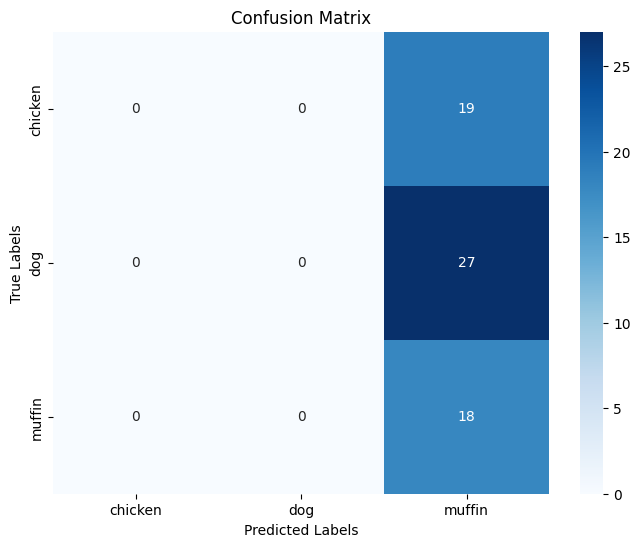

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

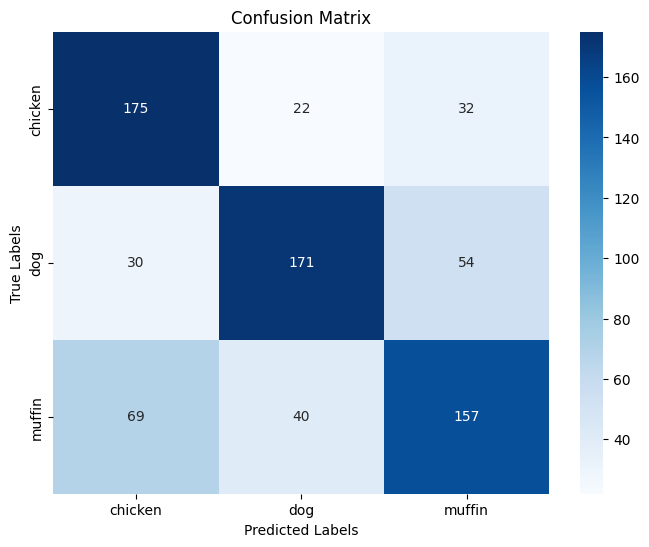

Validation: |          | 0/? [00:00<?, ?it/s]

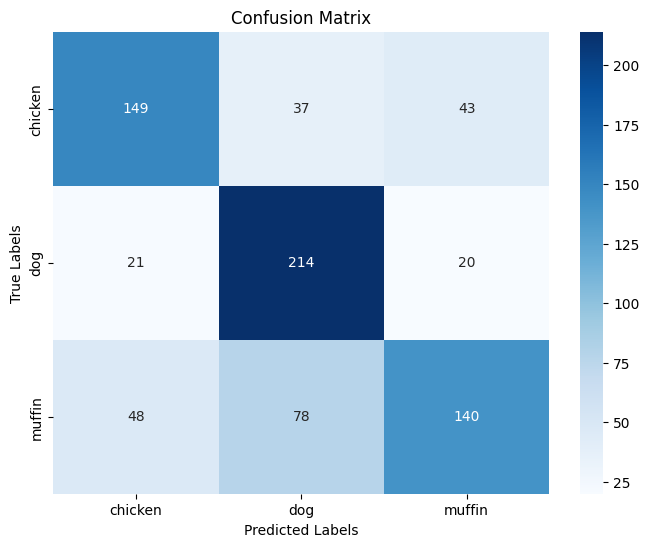

Validation: |          | 0/? [00:00<?, ?it/s]

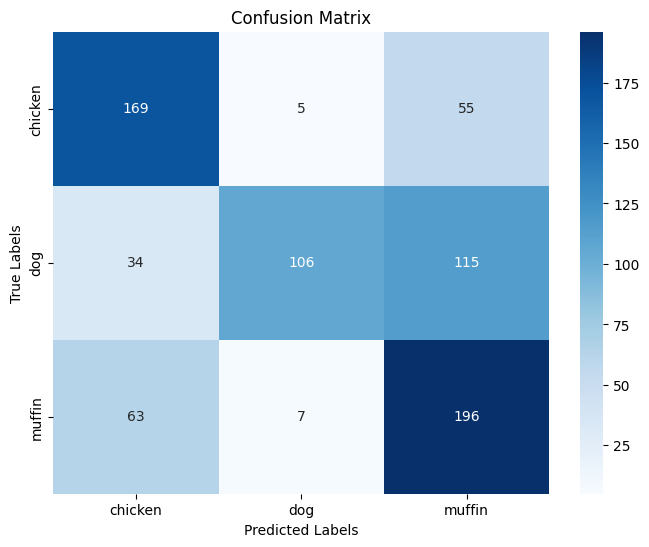

Validation: |          | 0/? [00:00<?, ?it/s]

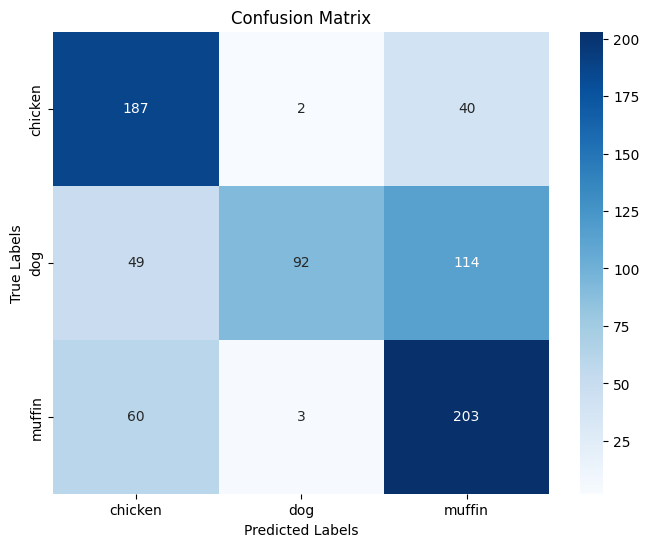

Validation: |          | 0/? [00:00<?, ?it/s]

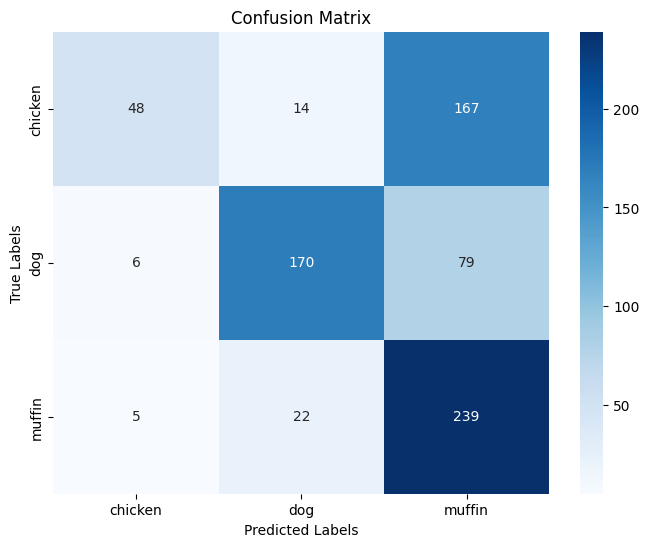

Validation: |          | 0/? [00:00<?, ?it/s]

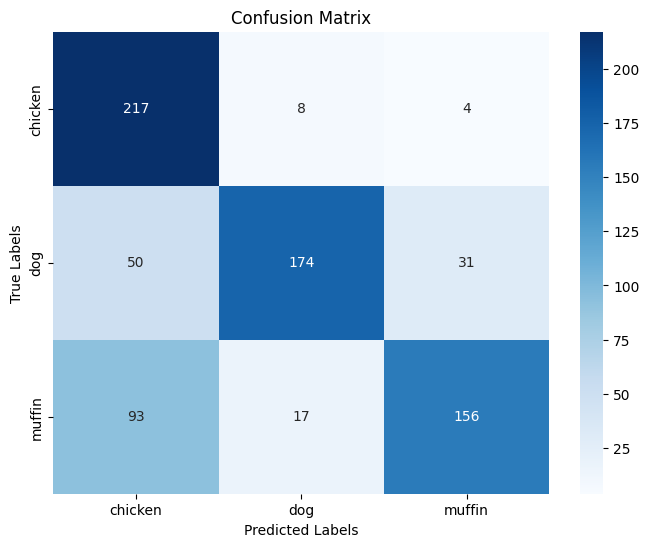

Validation: |          | 0/? [00:00<?, ?it/s]

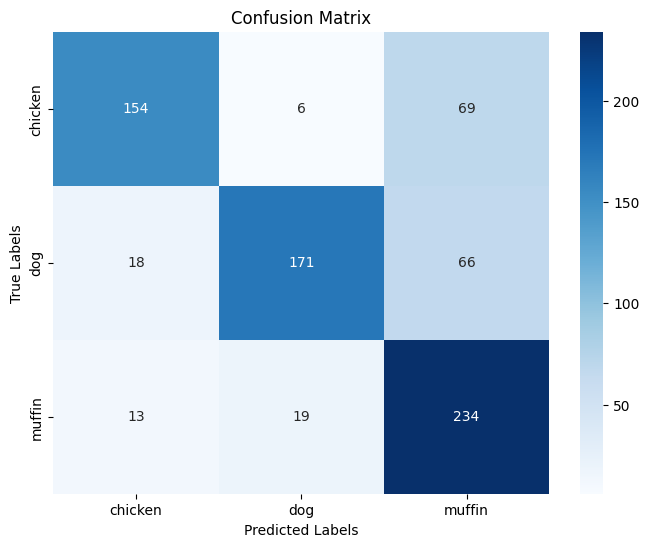

Validation: |          | 0/? [00:00<?, ?it/s]

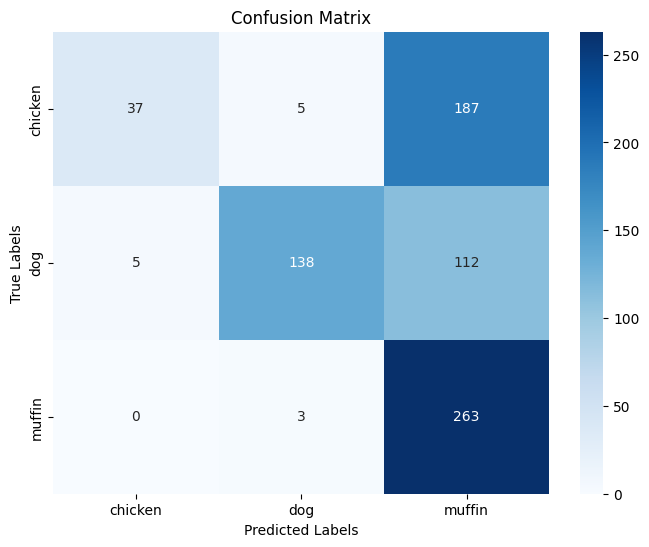

Validation: |          | 0/? [00:00<?, ?it/s]

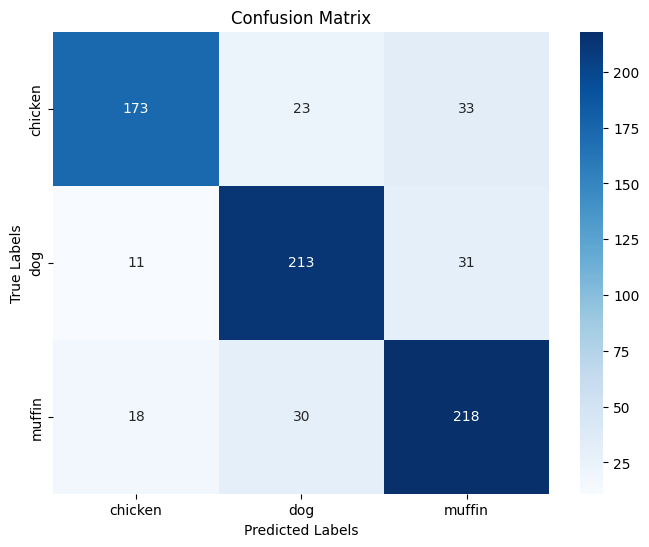

Validation: |          | 0/? [00:00<?, ?it/s]

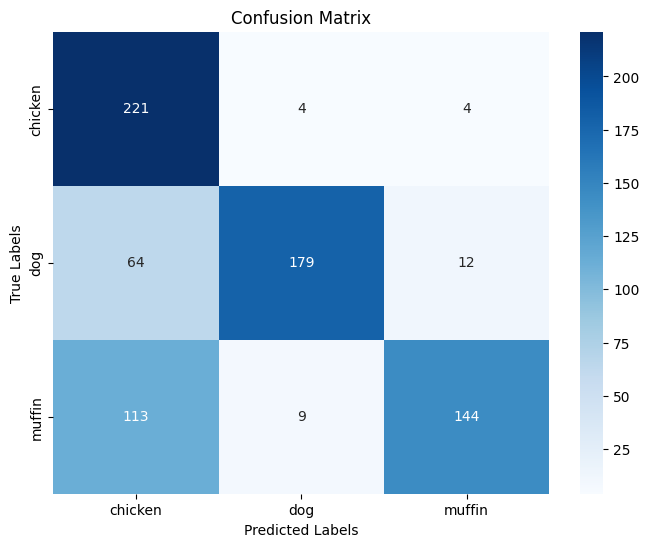

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


epoch,▁▁▁▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇████
train_acc_epoch,▁▃▄▄▅▅▆▇▇█
train_acc_step,▃▄▁▇▄█▆▄▅▅▅▆▅█
train_loss_epoch,█▆▆▅▄▄▃▂▂▁
train_loss_step,▇▆█▄▆▂▅▆▆▅▄▃▂▁
trainer/global_step,▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇███
val_acc,▄▄▂▃▂▆▆▁█▅
val_loss,▇▆▇▆▅▄▂█▁▃
epoch,9
train_acc_epoch,0.7433
train_acc_step,0.84375


In [14]:
wandb_logger = pl.loggers.WandbLogger(project="dl-practice-4-vision", log_model="all")
checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor="val_acc", mode="max")
trainer = pl.Trainer(
    max_epochs=num_epochs,
    precision="16-mixed",
    accelerator="gpu",
    devices=1,
    logger=wandb_logger,
    callbacks=[checkpoint_callback],
)
trainer.fit(lit_model, datamodule)
wandb.finish()